# **Сегментация пользователей**

## **1 | Background**

***


В практической части вебинара на простых примерах реализуем рассмотренные теоретические аспекты:


1.   **`RFM-анализ`** на транзакционных данных
2.   **`Кластеризация`** K-means
3.   **`Кластеризация`** DBSCAN
4.   **`Логистическая регрессия`** для сегментации


***

## **2 | RFM Анализ**

### **2.1. Загрузка данных**

Датасет содержит данные о транзакциях на уровне клиента по дате.

In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

In [5]:
def plot_distrib(df):
  # Построение распределений для каждой колонки
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Распределение для Recency
  sns.histplot(df['Recency'], kde=True, color='blue', ax=axes[0])
  axes[0].set_title('Distribution of Recency')
  axes[0].set_xlabel('Recency')
  axes[0].set_ylabel('Frequency')

  # Распределение для Frequency
  sns.histplot(df['Frequency'], kde=True, color='green', ax=axes[1])
  axes[1].set_title('Distribution of Frequency')
  axes[1].set_xlabel('Frequency')
  axes[1].set_ylabel('Frequency')

  # Распределение для Monetary
  sns.histplot(df['Monetary'], kde=True, color='red', ax=axes[2])
  axes[2].set_title('Distribution of Monetary')
  axes[2].set_xlabel('Monetary')
  axes[2].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

- Загружаем данные, сразу считывая даты в нужном формате
- В данных у нас отображаются три колонки:
    - **customer_id** : пользователь который совершил покупку
    - **trans_data** : дата покупки товара (что конкретно не уточняется)
    - **tran_amount** : сумма покупки

In [6]:
df = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])
print(df.shape)
df.head()

(125000, 3)


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [1]:
print("Нам даны транзакции за интервал:")
print(df['trans_date'].min(), df['trans_date'].max())

Нам даны транзакции за интервал:
2011-05-16 00:00:00 2015-03-16 00:00:00


#### Давность последней покупки

- RFM-анализ требует провести разбиение данных пол сумме, количеству и "давности" транзакций. 
- Сумма у нас есть, количество посчитаем позже группировкой. Не хватает "давности":
- Будем использовать 2015-04-01 как дату от которой надо посчитать количество дней от каждой покупки

In [8]:
sd = dt.datetime(2015,4,1)
df['days_from_last_transaction'] = (sd - df['trans_date']).dt.days
# возьмем транзакции за год
df = df[df['days_from_last_transaction'] <= 365]
print(df.shape)
df.head()

(30928, 4)


,customer_id,trans_date,tran_amount,days_from_last_transaction
1,CS4768,2015-03-15,39,17
7,CS5902,2015-01-30,89,61
14,CS5552,2014-12-29,78,93
18,CS3904,2014-07-20,103,255
30,CS2859,2015-02-27,77,33


In [6]:
# df.groupby('customer_id').agg(days_from_last_transaction=('tran_amount','min'))

Группируем для каждого клиента, находим количество дней от его последней покупки, количество покупок и сумма всех покупок клиента

In [9]:
# группируем данные в необходимый формат агрегации
rfmTable = df.groupby('customer_id').agg({
    'days_from_last_transaction': lambda x: x.min(), # Recency
    'customer_id': lambda x: len(x), # Frequency
    'tran_amount': lambda x: x.sum() # Monetary Value
    })
print(rfmTable.shape)
rfmTable.head()

(6763, 3)


,days_from_last_transaction,customer_id,tran_amount
customer_id,,,
CS1112,77,4,251
CS1113,51,6,393
CS1114,48,5,315
CS1115,27,3,248
CS1116,219,3,190


In [1]:
# для удобства переименуем колонки
rfmTable.rename(columns={'days_from_last_transaction': 'Recency',
                         'customer_id': 'Frequency',
                         'tran_amount': 'Monetary'}, inplace=True)
print(rfmTable.shape)
rfmTable.head()

(6763, 3)


,Recency,Frequency,Monetary
customer_id,,,
CS1112,77,4,251
CS1113,51,6,393
CS1114,48,5,315
CS1115,27,3,248
CS1116,219,3,190


Смотрим на распределение данных

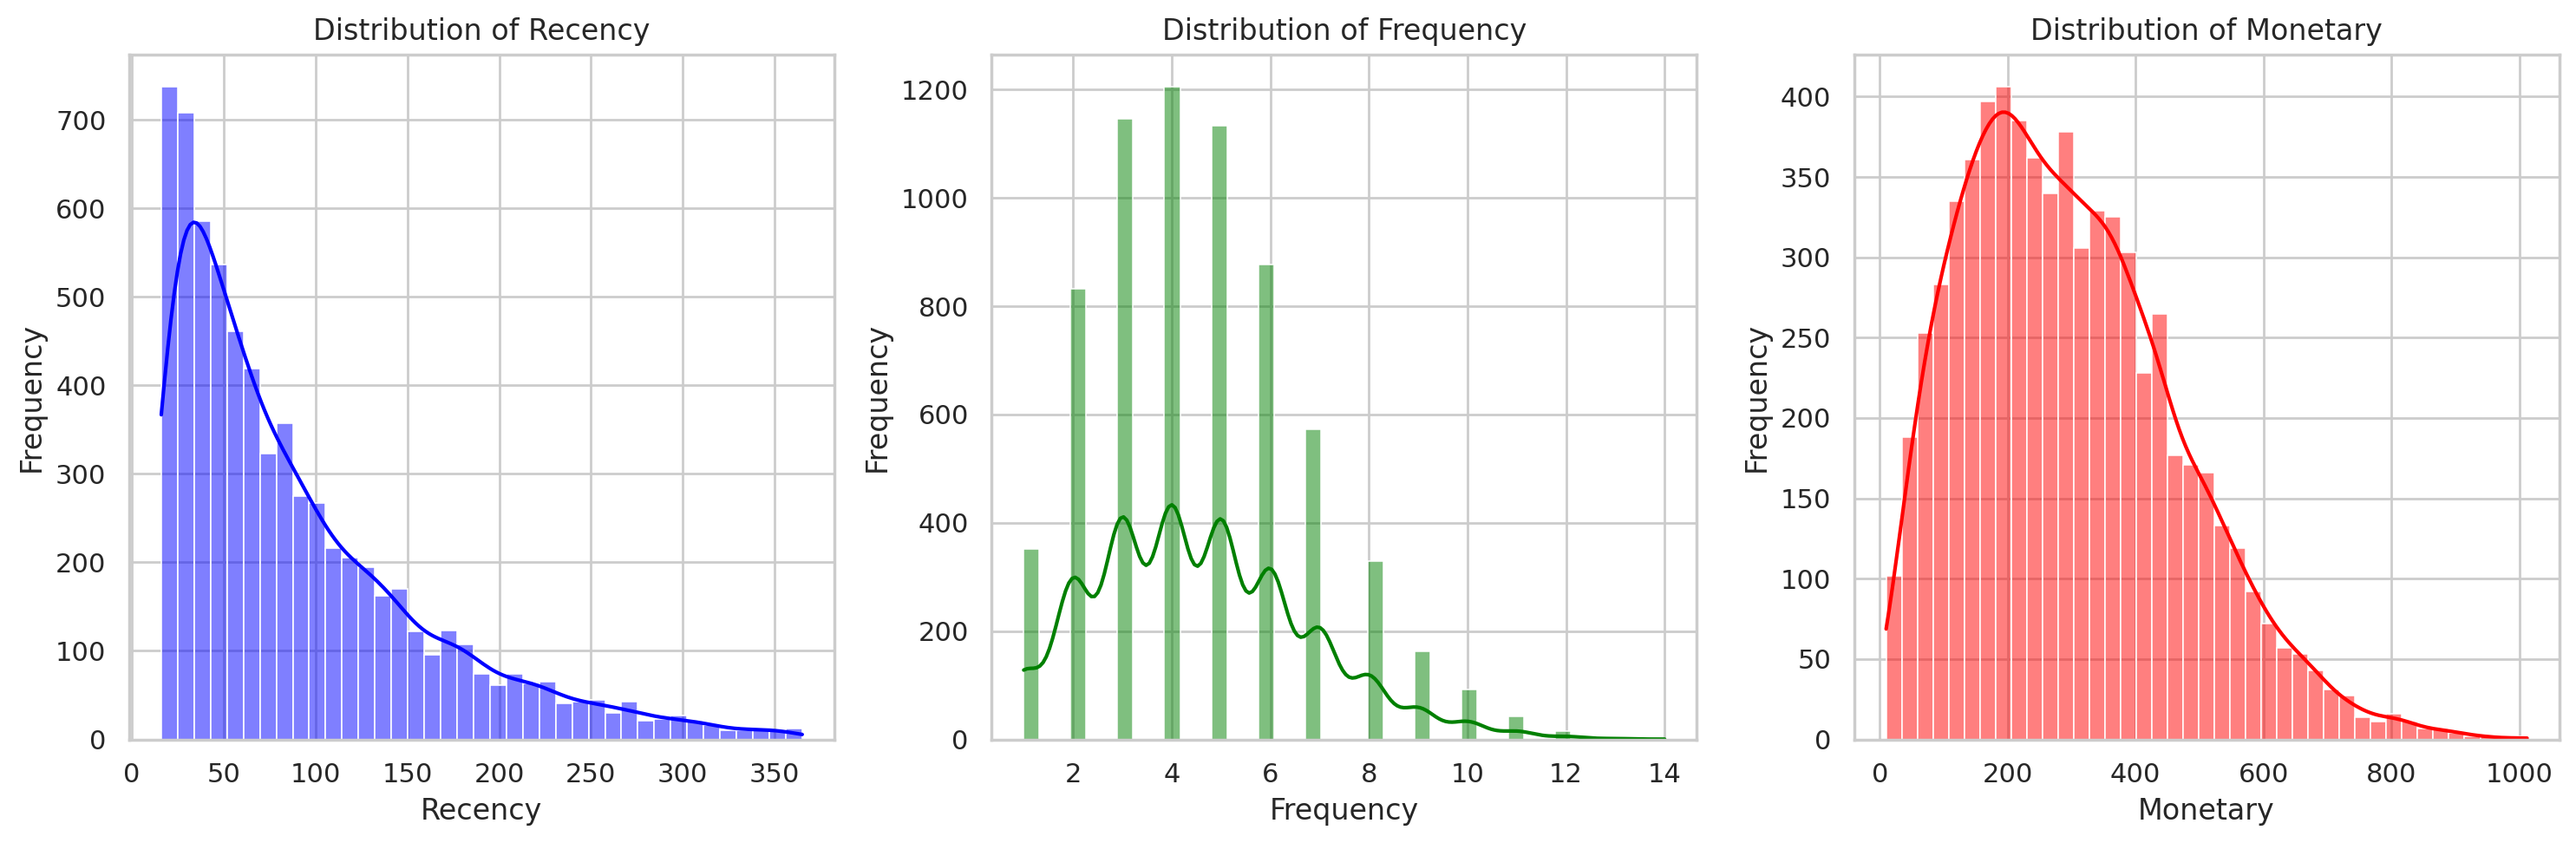

In [4]:
# распределение полученных фичей
plot_distrib(rfmTable)

Разделяем клиентов на три сегмента для всех трех колонок

In [ ]:
# Присвоение баллов по квантилям
rfmTable['R_Score'] = pd.qcut(rfmTable['Recency'], 3, labels=range(3, 0, -1))
rfmTable['F_Score'] = pd.qcut(rfmTable['Frequency'], 3, labels=range(3, 0, -1))
rfmTable['M_Score'] = pd.qcut(rfmTable['Monetary'], 3, labels=range(3, 0, -1))

Создаем одну метку из всех подвыборок для того чтобы их сегментировать

In [6]:
# Объединение баллов в один RFM-балл
rfmTable['RFM_Score'] = rfmTable['R_Score'].astype(str) + rfmTable['F_Score'].astype(str) + rfmTable['M_Score'].astype(str)
print(rfmTable.shape)
rfmTable.head()

(6763, 7)


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
CS1112,77,4,251,2,2,2,222
CS1113,51,6,393,2,1,1,211
CS1114,48,5,315,2,2,2,222
CS1115,27,3,248,1,3,2,132
CS1116,219,3,190,3,3,3,333


Смотрим на рпсспеределие RFM-сегментов клиентов

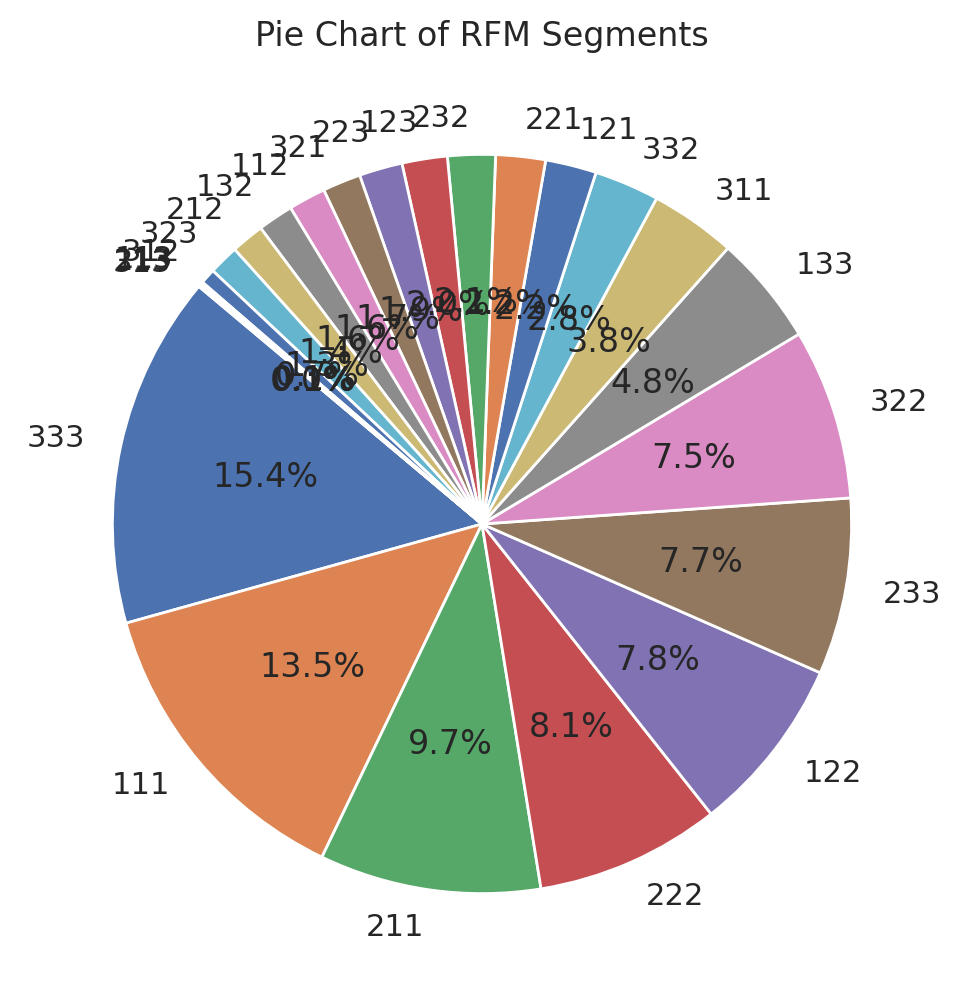

In [7]:
# Круговая диаграмма для RFM-сегментов
plt.figure(figsize=(6, 6))
rfm_counts = rfmTable['RFM_Score'].value_counts()
plt.pie(rfm_counts, labels=rfm_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of RFM Segments')
plt.show()

Посчитаем статистику для самых ативных клиетов 

In [8]:
# Постоянные клиенты, которые готовы регулярно покупать на большие суммы?
rfmTable[rfmTable['RFM_Score'] == '111'][['Recency',	'Frequency',	'Monetary']].agg(['count', 'mean', 'median', 'min', 'max'])

,Recency,Frequency,Monetary
count,916.000000,916.000000,916.000000
mean,29.145197,7.424672,523.518559
median,28.000000,7.000000,504.000000
min,16.000000,6.000000,360.000000
max,46.000000,14.000000,951.000000


Клиенты которые относительно недавно покупали и были активными

In [9]:
# относительно недавние клиенты, которые покупают со средней частотой на среднюю сумму?
rfmTable[rfmTable['RFM_Score'] == '322'][['Recency',	'Frequency',	'Monetary']].agg(['count', 'mean', 'median', 'min', 'max'])

,Recency,Frequency,Monetary
count,505.000000,505.000000,505.000000
mean,152.233663,4.368317,282.485149
median,143.000000,4.000000,283.000000
min,101.000000,4.000000,202.000000
max,295.000000,5.000000,359.000000


Не очень активные клиетны которые редко ходили и не очень много покупали

In [14]:
# самые неактивные и разовые клиенты?
rfmTable[rfmTable['RFM_Score'] == '333'][['Recency',	'Frequency',	'Monetary']].agg(['count', 'mean', 'median', 'min', 'max'])

,Recency,Frequency,Monetary
count,1044.000000,1044.000000,1044.000000
mean,193.834291,2.056513,109.831418
median,180.500000,2.000000,108.000000
min,101.000000,1.000000,10.000000
max,365.000000,3.000000,201.000000


## **2 | Кластеризация k-means**

Методы кластеризации доют нам возможность сегментировать данные на разные подгруппы

### K-means

General

- это метод кластеризациикоторый делить данные на К кластеров на основе схожости, минимизируя среднекваратическую ошибку разбиения
- У каждого центра есть свой центр массы
- нужно посчитать разницу между всеми нашими точками относительно центра нашего кластера
- эту сумму необходимо минимизировать 

Algorithm

- Выбор К начальных случайныхцентров 
- для каждого центра рассчитиваем растояние до каждого из К кластеров и относим эго к ближайшему
- Пересчитываем центры кластеров как среднее значение точек, принадлежащих каждому кластеру
- повторяем рассчет растояний и пепесчет центров до тех пор пока центры не перестанут значительно меняться

Плюсы

- простота и скорость 
- интерпретируемость

Минусы

- Выбок К
- чувствительно к начальным центройдам
- форма кластеров

Методы улучшения

- **`Метод локтя`** (определения оптимального количество кластеров на основе графика суммы квадратов ошибки)
- K-means++ : улучшение инициализации центройдлв для достижения более стабильных результатов 
- **`Силуэтный анализ`**: оценка качества клвастеров на основе внутрикластерного расстояния и расстояния до ближайшего кластера


#### Кластеризация Стоимости Домов 

- Данные относятся к домам, расположенным в штате Калифорния. 
- Это сводная статистика о недвижимости, основанная на данных переписи 1990 года.
- Попытаемся кластеризовать эти данные.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

Для кластеризации воспользуемся только 3 фичами

In [5]:
# загрузим данные
# в простом случае возьмем только три колонки
# можете проэкспериментировать с бОльшим набором данных
df = pd.read_csv('housing.csv',
                 usecols = ['longitude', 'latitude', 'median_house_value'])
print(df.shape)
df.head()

(20640, 3)


,longitude,latitude,median_house_value
0,-122.23,37.88,452600.0
1,-122.22,37.86,358500.0
2,-122.24,37.85,352100.0
3,-122.25,37.85,341300.0
4,-122.25,37.85,342200.0


Посмотрим на истинное расспределение стоимости домов (целевая метка)

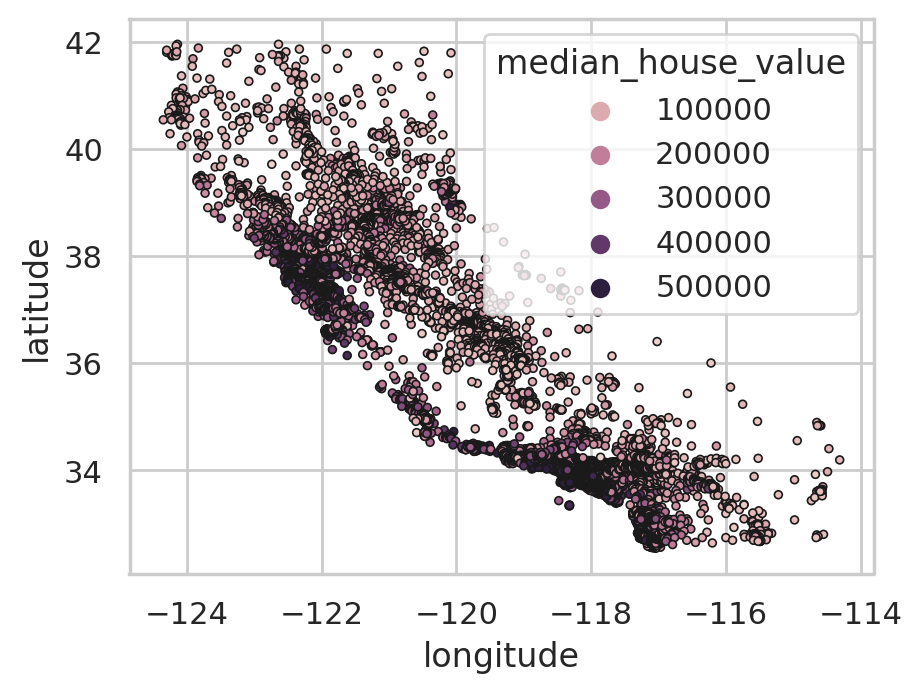

In [6]:
sns.scatterplot(data = df, 
                x = 'longitude', 
                y = 'latitude',
                hue = 'median_house_value',s=8,
                linewidth=0.6,
               edgecolor='k');

Разбиваем выборку на подвыборки 

In [7]:
# разделим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(df[['latitude', 'longitude']],
                                                    df[['median_house_value']],
                                                    test_size=0.33,
                                                    random_state=42)
print(X_train.shape, X_test.shape)

(13828, 2) (6812, 2)


Стандартизируем данные

In [8]:
# необходимо масштабировать данные
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

На глаз постараемся интуитивно выбрать параметры для кластеризации данных

In [9]:
# запустим клатеризацию на фиксированных парметрах
kmeans = KMeans(n_clusters = 3,
                random_state = 42,
                max_iter=300,
                n_init='auto')
kmeans.fit(X_train_norm)

KMeans(n_clusters=3, n_init='auto', random_state=42)

Выведем две метрики оценки кластера 

In [10]:
# среднееквадратическая ошибка внутри облако
print('SSE: ', kmeans.inertia_) 

# оценикает на сколько близко находится к нужнему кластеру и как далеко находится от других центров
print('silhouette', silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean'))

SSE:  0.16279422179147127
silhouette 0.7498110566149692


In [11]:
# на какой итерации сошелся алогритм?
kmeans.n_iter_

5

In [9]:
kmeans.labels_[:10]

array([1, 0, 1, 0, 0, 0, 0, 1, 2, 1], dtype=int32)

Посмотрим на результат кластеризации 

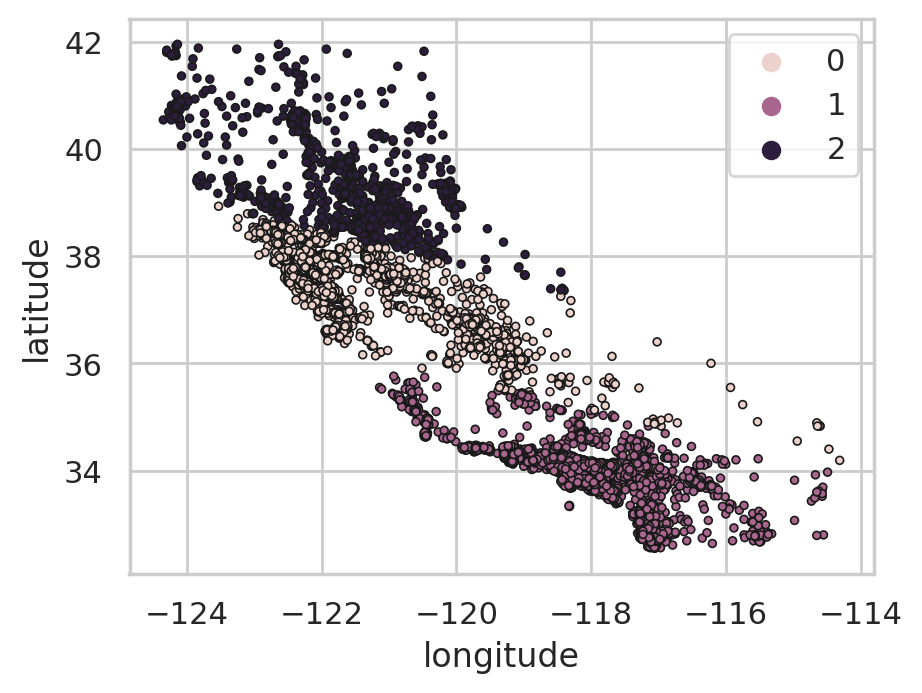

In [12]:
sns.scatterplot(data = X_train, 
                x = 'longitude', 
                y = 'latitude',
                hue = kmeans.labels_,
                s=8,linewidth=0.6,
                edgecolor='k');

#### Оптимизация по SSE

Постараемся оптимизировать гиперпраметры модели на основе метрики inertia

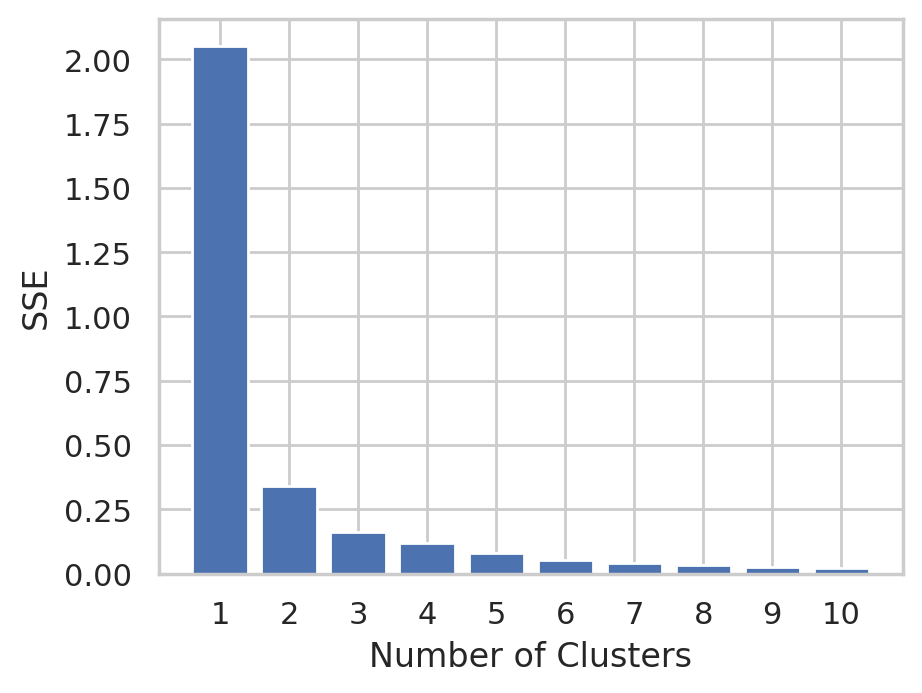

In [13]:
# посчитаем SSE на нескольких вариантах кластеров
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_norm)
    sse.append(kmeans.inertia_)

# метод локтя
plt.bar(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

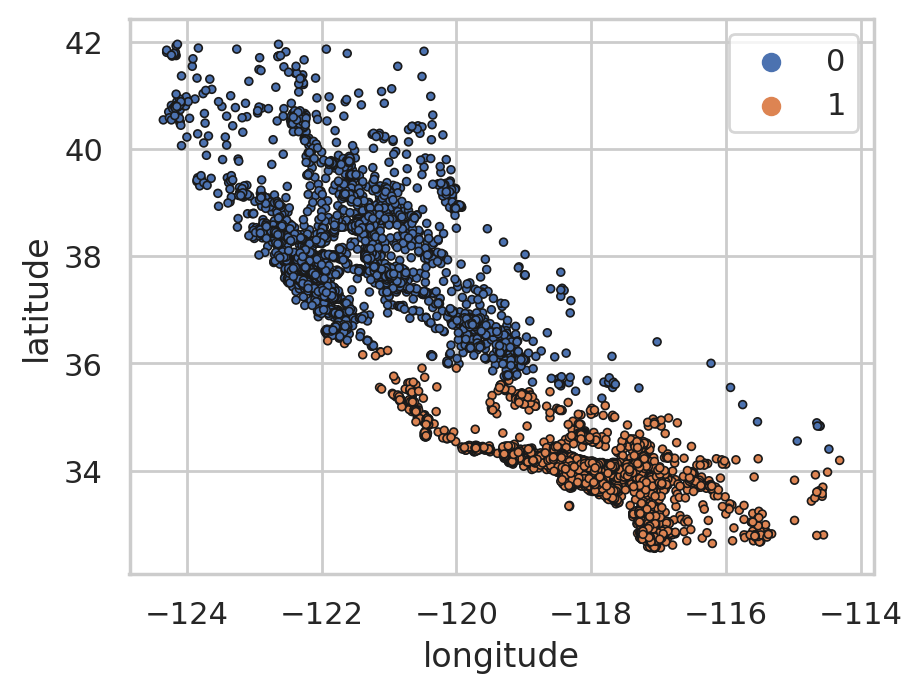

In [14]:
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
kmeans.fit(X_train_norm)

sns.scatterplot(data = X_train, 
                x = 'longitude', 
                y = 'latitude',
                hue = kmeans.labels_,
                s=8,linewidth=0.6,
                edgecolor='k');

In [16]:
!pip install kneed

 System commands are not supported in Juno (yet)


А если на глаз не нравится?

In [1]:
# если не на глаз

from kneed import KneeLocator

kl = KneeLocator(
     range(1, 11), 
    sse, 
    curve="convex", 
    direction="decreasing"
)

kl.elbow # оптималный 

2

### Оптимизация по метрики Silhouette

- Теперь посмотрим на качество кластеризации с точки зрения silhouette
- Переберем значение количество кластеров, и посчитаем silhouette

In [16]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_norm)
    score = silhouette_score(X_train_norm, kmeans.labels_)
    silhouette_coefficients.append(score)

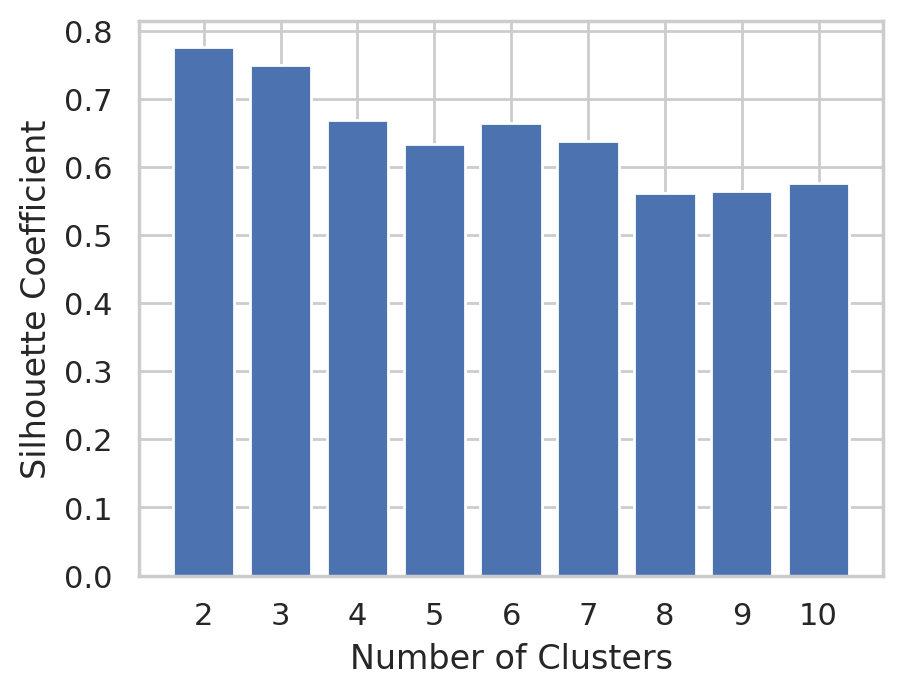

In [17]:
plt.bar(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

- Рекомендуется брать то число кластеров, после которого модель демонстрирует нестабильность. 
- Однако, могут быть экспертные требования, которые позволят от этого правила отойти

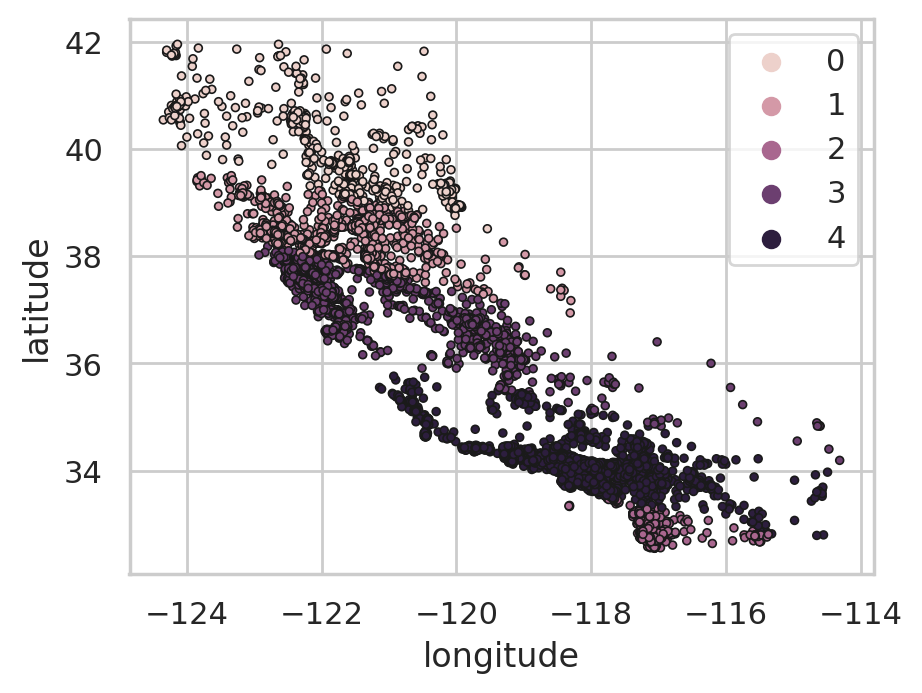

In [18]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(X_train_norm)

sns.scatterplot(data = X_train, 
                x = 'longitude', 
                y = 'latitude',
                hue = kmeans.labels_,
                s=8,linewidth=0.6,
                edgecolor='k');

Красиво. Но смысл разбиения не особо ясен.

## **3 | Кластеризация DBSCAN**

определение

- плотностной алгоритм пространственной кластеризации с присутсвием шума
- умеет работать с кластерами сложной формы
- умеет находить шумы

алгоритм

- задача; разбить толпу на кластеры
- все у кого есть хотя бы N соседа на расстоянии M метра берут в куки зеленые флажки 
- если меньше N соседа? Если хотя бы один сосед держит зеленый флаг, вручим желтые флажки (пограничный)
- красные : меньше трех соседей и нет соседей с зелеными флажками (outlier)

плюсы 

- обнаружение кластеров произвольной формы 
- работа с шумом ивыбросами
- не требует предварительного знания количества кластеров
- эффективен для больших наборов данных (по сравнению с кмеанс)

минусы 

- чувствительность к параметрам (2 параметра)
- трудности с кластеризацией данных с переменной плотностью 
- проблема с маштабируемостью для очень больших данных
- неопределенность при выборе параметров

- **`eps`** определяет максимальное расстояние между двумя точками, чтобы они считались соседями. Если **`eps`** слишком мал, многие точки останутся несвязанными; если слишком велик, все точки окажутся в одном кластере.



- **`min_samples`** определяет минимальное количество точек, необходимых для формирования плотного региона (кластера). Если **`min_samples`** слишком мал, многие выбросы будут классифицированы как кластеры; если слишком велик, многие кластеры не будут сформированы.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [29]:
db = DBSCAN(eps=20, min_samples=4)
db.fit(X_train)

DBSCAN(eps=20, min_samples=4)

In [30]:
DB_df = X_train[['latitude', 'longitude']].copy()
DB_df['Cluster'] = db.labels_
DB_df['Cluster'].value_counts()

0    13828
Name: Cluster, dtype: int64

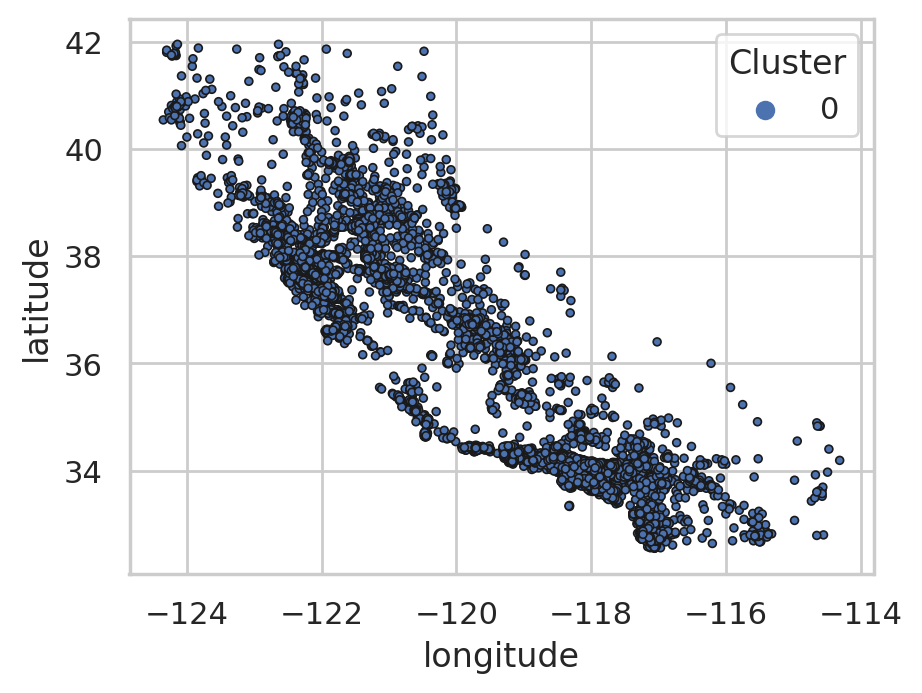

In [22]:
sns.scatterplot(data = DB_df, 
                x = 'longitude', 
                y = 'latitude',
                hue = DB_df['Cluster'],
                s=8,linewidth=0.6,
                edgecolor='k');

перебо параметров не оптималных подход, воспользуемя методом ближайших соседей

- переберем **`eps`** в премежутке [0.01, 0.1, 0.2, 0.3, 0.4]
- так же перебересм **`min_samples`** в премежутке [3, 5, 7, 10, 20, 30, 40, 100]
- для каждого посчитаем количество лейбелов

In [32]:
from sklearn.neighbors import NearestNeighbors

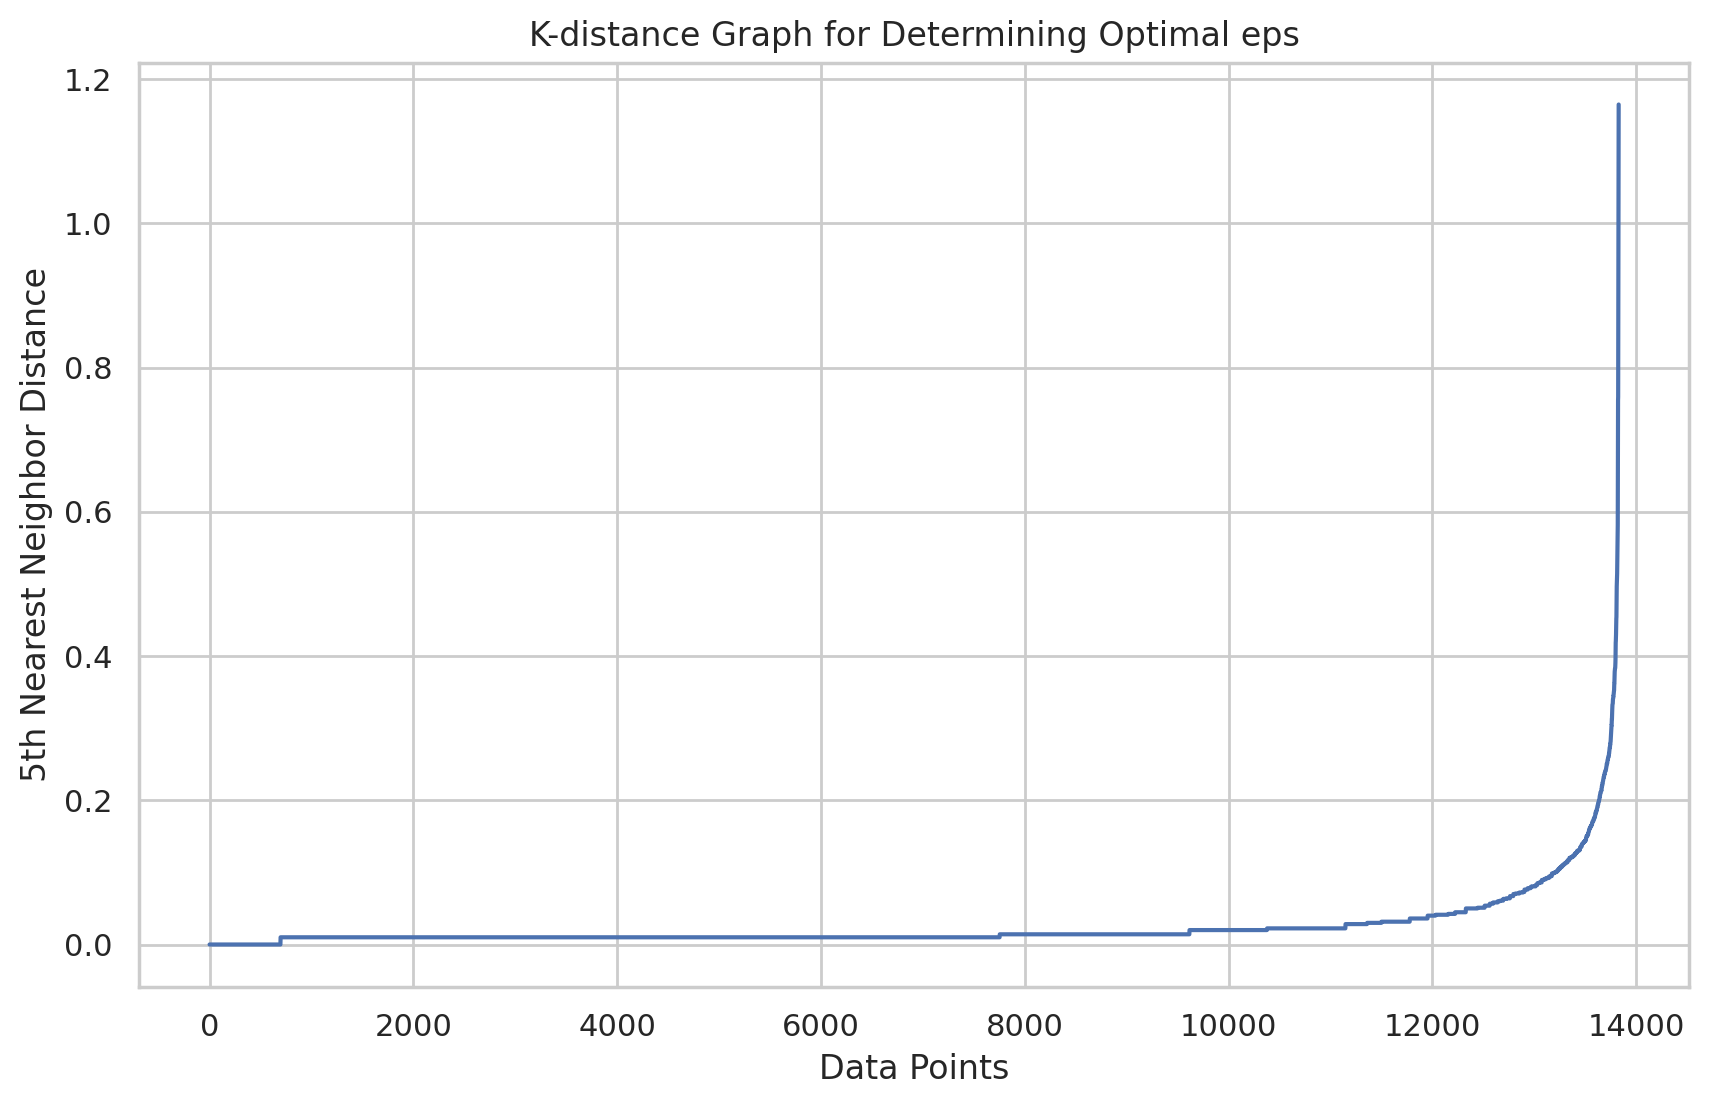

eps: 0.01, min_samples: 3, Number of clusters: 1321
eps: 0.01, min_samples: 5, Number of clusters: 719
eps: 0.01, min_samples: 7, Number of clusters: 362
eps: 0.01, min_samples: 10, Number of clusters: 135
eps: 0.01, min_samples: 20, Number of clusters: 2
eps: 0.01, min_samples: 30, Number of clusters: 0
eps: 0.01, min_samples: 40, Number of clusters: 0
eps: 0.01, min_samples: 100, Number of clusters: 0
eps: 0.1, min_samples: 3, Number of clusters: 76
eps: 0.1, min_samples: 5, Number of clusters: 59
eps: 0.1, min_samples: 7, Number of clusters: 48
eps: 0.1, min_samples: 10, Number of clusters: 43
eps: 0.1, min_samples: 20, Number of clusters: 36
eps: 0.1, min_samples: 30, Number of clusters: 31
eps: 0.1, min_samples: 40, Number of clusters: 23
eps: 0.1, min_samples: 100, Number of clusters: 10
eps: 0.2, min_samples: 3, Number of clusters: 24
eps: 0.2, min_samples: 5, Number of clusters: 20
eps: 0.2, min_samples: 7, Number of clusters: 14
eps: 0.2, min_samples: 10, Number of clusters: 1

In [36]:
"""

расстояния до 5-го ближайшего соседа

"""

# Пример данных (замените на ваши данные)
DB_df = X_train[['latitude', 'longitude']].copy()
X = DB_df[['latitude', 'longitude']].values

# Построение графика "K расстояний"
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:, 4], axis=0)  

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('K-distance Graph for Determining Optimal eps')
plt.show()

"""

Методом перебором

"""

# Пример тестирования различных значений параметров eps и min_samples
for eps in [0.01, 0.1, 0.2, 0.3, 0.4]:
    for min_samples in [3, 5, 7, 10, 20, 30, 40, 100]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(X)
        DB_df['Cluster'] = db.labels_
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        print(f'eps: {eps}, min_samples: {min_samples}, Number of clusters: {n_clusters}')

In [37]:
db = DBSCAN(eps=0.18, min_samples=100)
db.fit(X_train)

DBSCAN(eps=0.18, min_samples=100)

In [38]:
DB_df = X_train[['latitude', 'longitude']].copy()
DB_df['Cluster'] = db.labels_

DB_df['Cluster'].value_counts()

 0    5819
 1    3048
-1    2422
 2    1013
 4     552
 6     491
 3     322
 5     161
Name: Cluster, dtype: int64

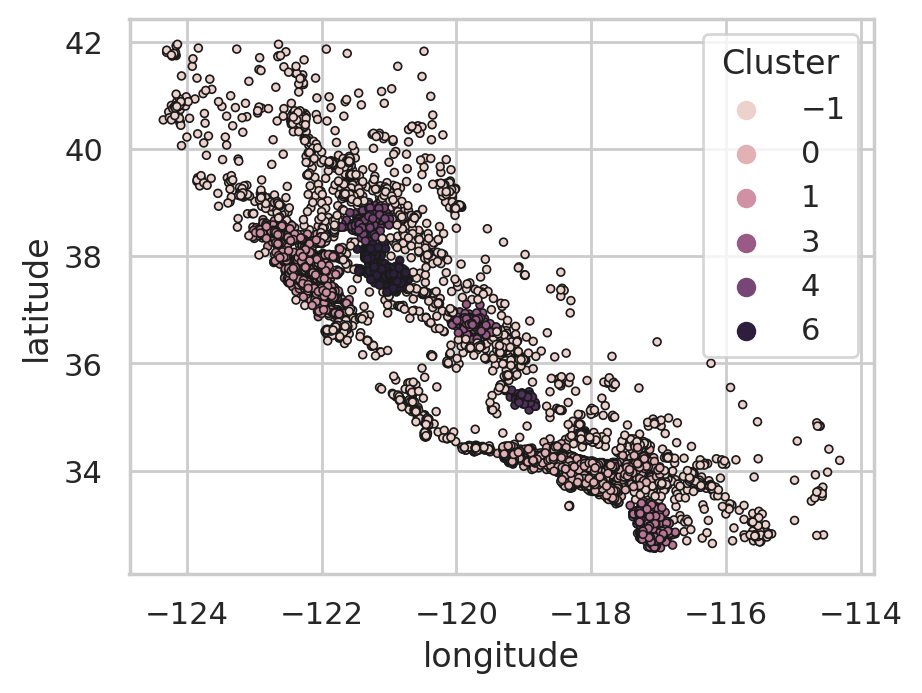

In [40]:
sns.scatterplot(data = DB_df, 
                x = 'longitude', 
                y = 'latitude',
                hue = DB_df['Cluster'],
                s=8,linewidth=0.6,
                edgecolor='k');

В таком случае уже можно оценить полученные кластеры с точки зрения логики.

## **4 | Логистическая Регрессия**


**Логистическая регрессия**

- Метод статистического анализа используеммый для предсказания **бинарного исхода** (класса) на основе одной или нескольких независимых переменных
- Лог регрессия помогает нам **сегментировать пользователей** на две группы (Бинарный исход)
- Лог рег помогает нам понять верятность принадлежности двум классом
- **Интерпретация признаков** будет помогать бизнесу понять с кем нужно в первую очередь пообщаться 

## **4.1. На примере**

Задача классификации пациентов на наличия диабета

- Датасет взят из Национального института диабет и заболеваний органов пищеварения и почек
- Данные предлагаются для решения задачи диагностики наличия у пациента диабета на основе измерений (данные о пользователе)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import pandas as pd

In [9]:
df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Признаки пользоватей

- **Pregnancies** : Number of times pregnant
- **Glucose** : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- **BloodPressure** : Diastolic blood pressure (mm Hg)
- **SkinThickness** : Triceps skin fold thickness (mm)
- **Insulin** : 2-Hour serum insulin (mu U/ml)
- **BMI** : Body mass index (weight in kg/(height in m)^2)
- **DiabetesPedigreeFunction** : Diabetes pedigree function
- **Age** : Age (years)
- **Outcome** : Class variable (0 or 1)

In [10]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

## **4.2. Подвыборки**

Разбиваем данные на две подвыборки

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(576, 8) (192, 8)


In [12]:
y.mean()

0.3489583333333333

## **4.3. Обучение модели**

Обучаем модель на одной из подвыборок

In [13]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [14]:
target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.80      0.77      0.79       123
   with diabetes       0.62      0.65      0.63        69

        accuracy                           0.73       192
       macro avg       0.71      0.71      0.71       192
    weighted avg       0.73      0.73      0.73       192



## **4.4. Оцениваем обобщающию способность**

**Предсказываем на новых данных**

Нам нужно сделать предсказание на отложенной выборке, и получить оцену обобщения модели на новых данных

In [16]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
y_pred_proba[:10]

array([0.27138722, 0.18792281, 0.10917411, 0.15183889, 0.47795318,
       0.44452342, 0.0140959 , 0.62424835, 0.56286436, 0.78383318])

**Оценка модели**

Оцениваем бинарную модель у которой есть дисбаланс классов на **ROC-AUC** кривой

- Только если модель показывает хороший результат, можем примтупать к интерпретации 


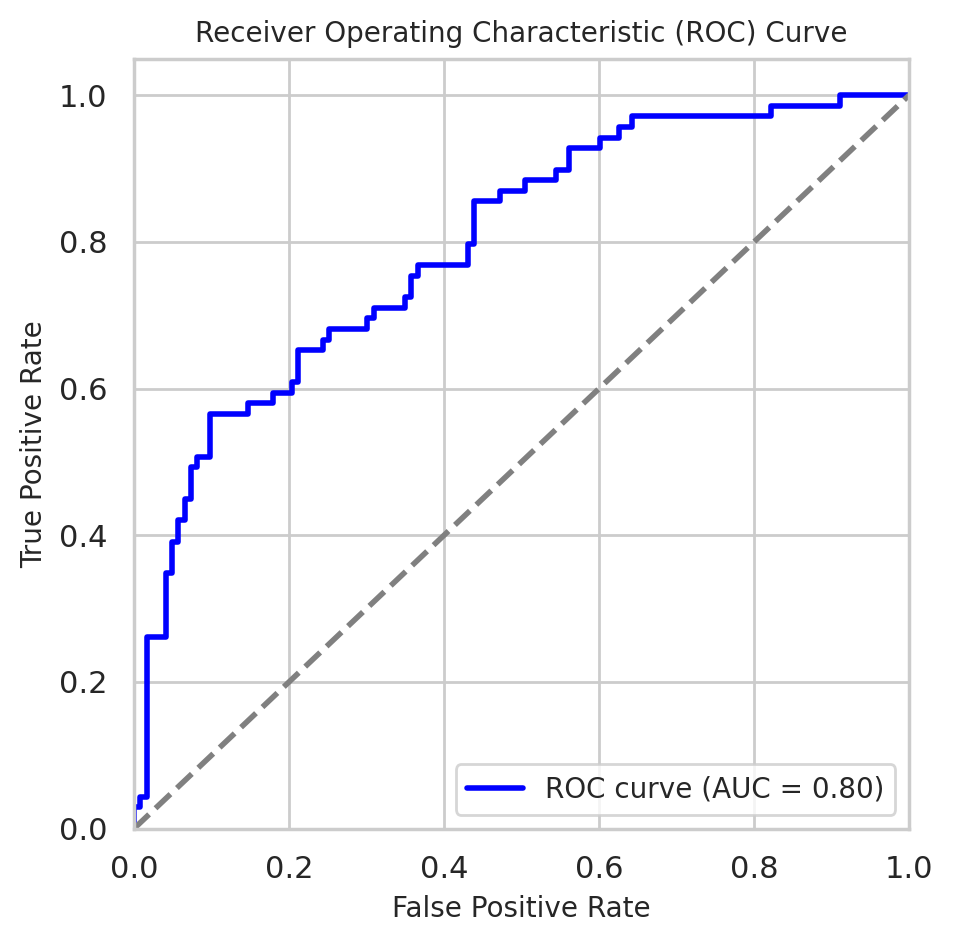

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Построение графика
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=10)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

## **4.5. Интерпретируем важность признаков**

**Интерпретируем важность признаков**

Воспользуемся библиотекой **SHAP** для понимания важности признаков и их влияние и как вообще их интерпритировать

In [56]:
import shap

In [57]:
explainer = shap.Explainer(
    logreg, X_train, feature_names=X_train.columns
)
shap_values = explainer(X_test)

**Некоторые выводы:**
- Чем выше BMI, тем выше вероятность наличия диабета
- Чем выше возраст, тем более вероятно что у пациента диабет 

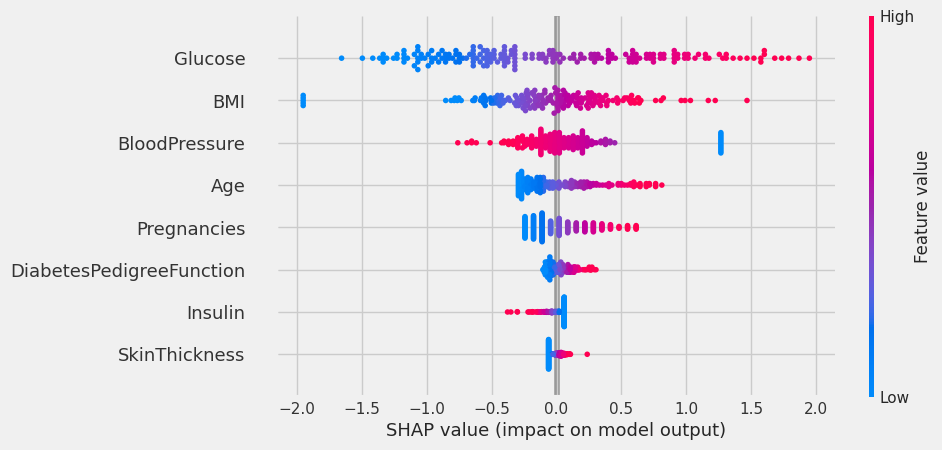

In [ ]:
shap.plots.beeswarm(shap_values)

Бинарные классификатор дает бизнессу понять с кем нужно общаться 